In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from sim_modules.testfuncs import gen_in_out_one_in_subs

import sys

In [344]:
class RNN():
    
    def __init__(self,**kwargs):
        
        self.N = kwargs.get('N',1000)
        self.dim_in = kwargs.get('dim_in',1)
        self.dim_out = kwargs.get('dim_out',1)
        
        self.cf = kwargs.get('cf',.1)
        
        self.eps_a = kwargs.get('eps_a',.01)
        self.eps_w_out = kwargs.get('eps_w_out',.01)
        
        self.W = np.random.normal(0.,1./(self.N*self.cf)**.5,(self.N,self.N))
        self.W *= (np.random.rand(self.N,self.N) <= self.cf)
        self.W[range(self.N),range(self.N)] = 0.
        
        self.w_in = np.random.normal(0.,1.,(self.N,self.dim_in))
        self.w_out = np.random.normal(0.,1.,(self.dim_out,self.N+1))
        self.w_out[:,0] = 0.
        
        self.a = np.ones((self.N))*kwargs.get('a',.9)
    
    def f(self,x):
        return np.tanh(x)
    
    def check_data_in_comp(self,data):

        if len(data.shape)==1:
            if self.dim_in != 1:
                print("input dimensions do not fit!")
                sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_in):
            print("input dimensions do not fit!")
            sys.exit()

        return data

    def check_data_out_comp(self,data):

        if len(data.shape)==1:
            if self.dim_out != 1:
                print("output dimensions do not fit!")
                #sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_out):
            print("output dimensions do not fit!")
            #sys.exit()

        return data
    
    def run_trial(self,u_in,u_out,t_BPTT=20):
        
        T = u_in.shape[0]
        
        y = np.zeros((T,self.N+1))
        y[:,0] = 1.
        
        X = np.zeros((T,self.N))
        
        err = np.ndarray((T,self.dim_out))
        
        O = np.ndarray((T,self.dim_out))
        
        for t in tqdm(range(1,T),disable=True):
            
            X[t,:] = self.W @ y[t-1,1:] + self.w_in @ u_in[t,:]
            
            y[t,1:] = self.f(self.a*X[t,:])
            
            O[t,:] = self.w_out @ y[t,:]
            
            err[t,:] = O[t,:] - u_out[t,:]
        
        ### throw away all except the last t_BPTT time steps:
        X = np.array(X[-t_BPTT:,:])
        y = np.array(y[-t_BPTT:,:])
        err = np.array(err[-t_BPTT:,:])
        
        da = np.zeros((self.N))
        dw_out = np.zeros((self.dim_out,self.N+1))
        
        dLdy = np.zeros((t_BPTT,self.N))
        
        dLdy[-1,:] = self.w_out[:,1:].T @ err[-1,:]
        
        for t in range(t_BPTT-1,0,-1):
            
            dLdy[t-1,:] += self.w_out[:,1:].T @ err[t-1,:]
            dLdy[t-1,:] += (dLdy[t,:]*self.a*(1.-y[t,1:]**2.)) @ self.W
            
            dw_out -= np.outer(err[t,:],y[t,:])/t_BPTT
            da -= dLdy[t,:]*(1.-y[t,1:]**2.)*X[t,:]/t_BPTT
        
        self.w_out += self.eps_w_out*dw_out
        self.a += self.eps_a*da.mean()
        
        return (err**2.).sum(axis=1).mean()
    
    def learn_w_out_trial(self,u_in,u_target,reg_fact=.01,show_progress=False):
        
        u_in = self.check_data_in_comp(u_in)
        u_target = self.check_data_out_comp(u_target)
        
        n_t = u_in.shape[0]
        
        
        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        
        y[0,1:] = self.f(self.a*(self.w_in @ u_in[0,:]))


        for t in tqdm(range(1,n_t),disable=not(show_progress)):

            y[t,1:] = self.f(self.a*(self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:]))

        self.w_out[:,:] = (np.linalg.inv(y.T @ y + reg_fact*np.eye(self.N+1)) @ y.T @ u_target).T
    
    def predict_data(self,data,return_reservoir_rec=False):

        data = self.check_data_in_comp(data)

        n_t = data.shape[0]

        u_in = data

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        y[0,1:] = self.f(self.a*(self.w_in @ u_in[0,:]))

        for t in tqdm(range(1,n_t)):

            y[t,1:] = self.f(self.a*(self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:]))

        out = (self.w_out @ y.T).T
        if self.dim_out == 1:
            out = out[:,0]

        if return_reservoir_rec:
            return (out,y)
        else:
            return out

In [355]:
rnn = RNN(eps_a=0.1,eps_w_out=0.0,a=.9)

tau_task = 10

n_trials = 500
t_run_trial = 50
t_learn_w_out = 5*rnn.N
t_BPTT = 2*tau_task

w_out_rec = np.ndarray((n_trials,rnn.dim_out,rnn.N+1))
a_rec = np.ndarray((n_trials,rnn.N))
Loss_rec = np.ndarray((n_trials))

#'''
# pretrain w_out_offline
u_in, u_out = gen_in_out_one_in_subs(t_learn_w_out,tau_task)
u_in = np.array([u_in]).T
u_out = np.array([u_out]).T

print("pretraing w_out...")
rnn.learn_w_out_trial(u_in,u_out,0.01,show_progress=True)
#'''

print("training with BPTT...")
for n in tqdm(range(n_trials),disable=False):

    ### learn gain with BPTT
    u_in, u_out = gen_in_out_one_in_subs(t_run_trial,tau_task)
    u_in = np.array([u_in]).T
    u_out = np.array([u_out]).T

    Loss_rec[n] = rnn.run_trial(u_in,u_out,t_BPTT=t_BPTT)
    ###


    w_out_rec[n,:,:] = rnn.w_out
    a_rec[n,:] = rnn.a

# post-train w_out_offline
u_in, u_out = gen_in_out_one_in_subs(t_learn_w_out,tau_task)
u_in = np.array([u_in]).T
u_out = np.array([u_out]).T

print("post-traing w_out...")
rnn.learn_w_out_trial(u_in,u_out,0.01,show_progress=True)


# testing
print("testing performance")
t_test_w_out = 10000
u_in_test, u_out_test = gen_in_out_one_in_subs(t_test_w_out,tau_task)
u_in_test = np.array([u_in_test]).T
u_out_test = np.array([u_out_test]).T

u_out_pred = rnn.predict_data(u_in_test)

pretraing w_out...


training with BPTT...


post-traing w_out...


testing performance


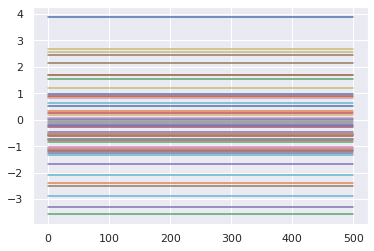

In [356]:
plt.plot(w_out_rec[:,0,:50])
plt.show()

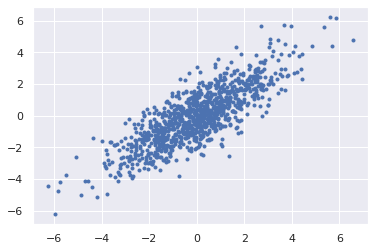

In [357]:
plt.plot(rnn.w_out[0,:],w_out_rec[-1,0,:],'.')
plt.show()

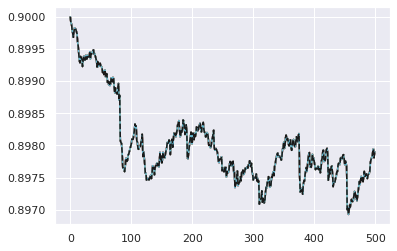

In [358]:
plt.plot(a_rec[:,:10])
plt.plot(((a_rec**2.).sum(axis=1)/rnn.N)**.5,'--',c='k')
plt.show()

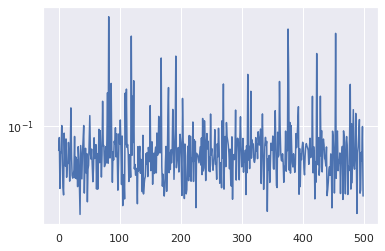

In [359]:
plt.plot(Loss_rec)
plt.yscale("log")
plt.show()

0.07221267698424381


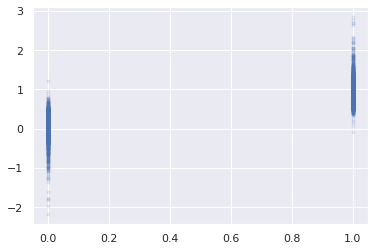

In [360]:
plt.plot(u_out_test[:,0],u_out_pred,'.',alpha=0.1)
print(((u_out_test[:,0]-u_out_pred)**2.).mean())
plt.show()

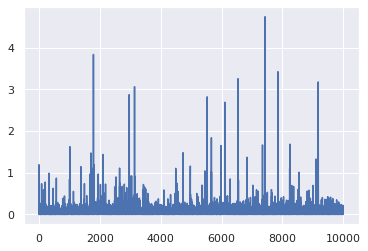

In [361]:
plt.plot(((u_out_test[:,0]-u_out_pred)**2.))
plt.show()

## Using a Combination of Grad Descent and Matrix Inversion

In [119]:
rnn = RNN(eps_a=0.005,eps_w_out=0.)

tau_task = 10

n_rounds = 10
n_trials = 100
t_run_trial = 50
t_learn_w_out = 5*rnn.N
t_BPTT = 2*tau_task

w_out_rec = np.ndarray((n_trials*n_rounds,rnn.dim_out,rnn.N+1))
a_rec = np.ndarray((n_trials*n_rounds,rnn.N))
Loss_rec = np.ndarray((n_trials*n_rounds))


for m in tqdm(range(n_rounds)):
    
    # learn w_out_offline
    u_in, u_out = gen_in_out_one_in_subs(t_learn_w_out,tau_task)
    u_in = np.array([u_in]).T
    u_out = np.array([u_out]).T

    rnn.learn_w_out_trial(u_in,u_out,0.01,show_progress=False)
    
    for n in tqdm(range(n_trials),disable=True):
                
        ### learn gain with BPTT
        u_in, u_out = gen_in_out_one_in_subs(t_run_trial,tau_task)
        u_in = np.array([u_in]).T
        u_out = np.array([u_out]).T

        Loss_rec[m*n_trials + n] = rnn.run_trial(u_in,u_out,t_BPTT=t_BPTT)
        ###
        
        
        w_out_rec[m*n_trials + n,:,:] = rnn.w_out
        a_rec[m*n_trials + n,:] = rnn.a



# test
t_test_w_out = 10000
u_in_test, u_out_test = gen_in_out_one_in_subs(t_test_w_out,tau_task)
u_in_test = np.array([u_in_test]).T
u_out_test = np.array([u_out_test]).T

u_out_pred = rnn.predict_data(u_in_test)